In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
import warnings
from TESStools import *
from astroML.time_series import ACF_scargle,ACF_EK

In [2]:
tid = 179305185

In [3]:
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']

pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 

good_fs, good_amps, good_phases = prewhiten(time, flux, err)
harmonics = harmonic_search(good_fs)
combos = combo_search(good_fs)

f_Ny = 322.8060468379108, f_R = 0.0177879072510214
10
20
30
40
50
60
70
Found 71 frequencies
41 unique frequencies


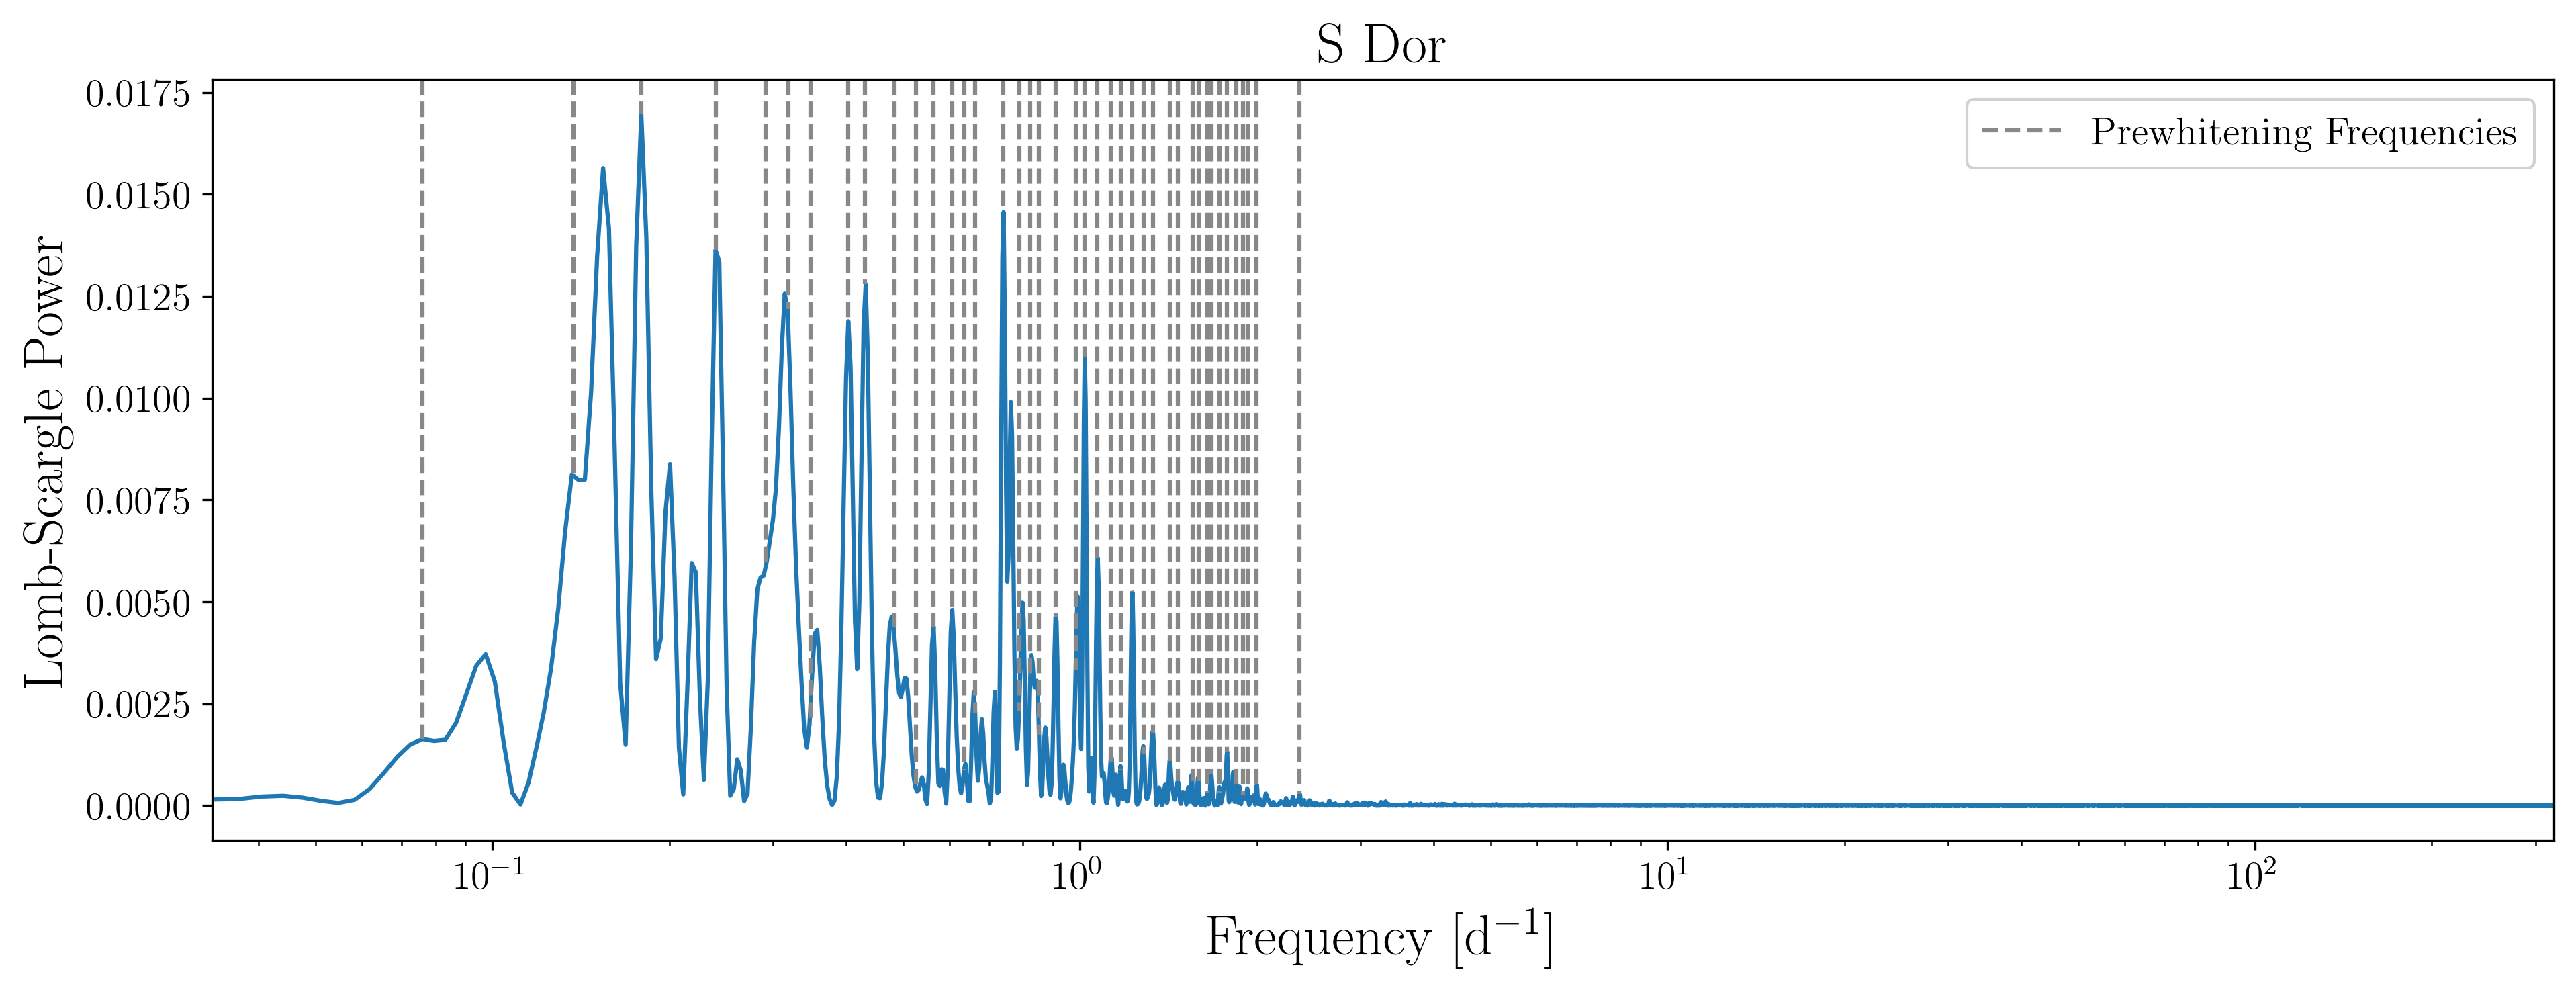

In [4]:
fig = plt.figure(figsize=(15,5),dpi=300)

plt.plot(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power', xscale='log', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
       
ax.set(ylim=ylim)
        
plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
ax.set_title('S Dor',fontsize=20) 
plt.savefig('../plots/SDor_periodogram.pdf')

[0.08194736 0.25312258 0.16582783 0.58976342 0.44486563]


/Users/carina/anaconda/lib/python3.5/site-packages/astroML/time_series/ACF.py:133: RuntimeWarning: invalid value encountered in true_divide
  ACF /= M
/Users/carina/anaconda/lib/python3.5/site-packages/astroML/time_series/ACF.py:135: RuntimeWarning: divide by zero encountered in true_divide
  return ACF, np.sqrt(2. / M), bins
/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:73: RuntimeWarning: invalid value encountered in greater
  if np.all(p[i] > p[i -width:i])&np.all(p[i] > p[i + 1:i+width+1])&(p[i]>FAL):


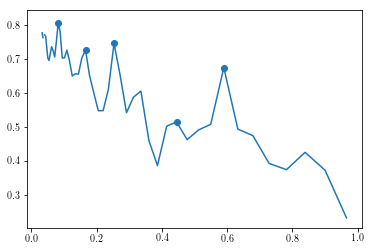

In [7]:
C_EK, C_EK_err, bins = ACF_EK(freq[freq<=2], power[freq<=2], 0.001*power[freq<=2], bins=np.logspace(-1.5, 0, 50))
f_EK = 0.5 * (bins[1:] + bins[:-1])
plt.plot(f_EK,C_EK)
f,p = peak_finder(f_EK,C_EK,10,width=3)
plt.scatter(f,p)
print(f)

In [ ]:
harmonics

In [7]:
combos

array([[0.17914669, 0.17914669, 0.40287251, 0.13744498, 0.48307755,
        0.98355185, 0.98355185, 0.63478994],
       [0.48307755, 1.46672799, 1.01866464, 0.52554769, 0.98355185,
        0.60660139, 0.66258409, 1.72867338],
       [0.66258409, 1.6460147 , 1.42147429, 0.66258409, 1.46672799,
        1.59025206, 1.6460147 , 2.36401361]])

In [13]:
dom, sec

(0.1791941727917088, 0.741292041923985)

In [8]:
# Now let's do some of the GP stuff on this with twin SHOs
gp = dSHO_maxlikelihood(lc)

Initial log likelihood: 204889.14054679289
Final log likelihood: 206684.06046729133
Maximum Likelihood Soln: OrderedDict([('kernel:terms[0]:log_S0', -12.892709770490093), ('kernel:terms[0]:log_omega0', 1.0780105408788752), ('kernel:terms[1]:log_S0', -14.29854817400825), ('kernel:terms[1]:log_Q', 0.4751960301575188), ('kernel:terms[1]:log_omega0', 1.8804870972648935), ('kernel:terms[2]:log_sigma', -7.966132138478449)])


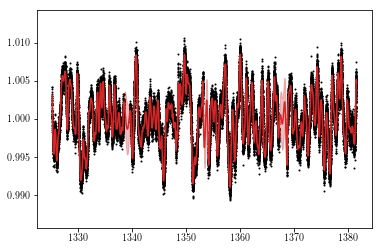

In [9]:
x = np.linspace(np.min(lc['Time']), np.max(lc['Time']), 5000)
pred_mean, pred_var = gp.predict(lc['NormFlux'], x, return_var=True)
pred_std = np.sqrt(pred_var)

plt.scatter(lc['Time'], lc['NormFlux'], s=1, c='k')
plt.plot(x, pred_mean, color='C3')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='C3', alpha=0.3,
                 edgecolor="none")

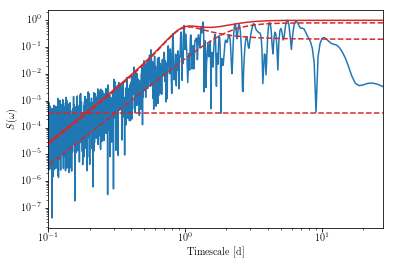

In [11]:
omega = np.exp(np.linspace(np.log(2.0*np.pi/28.0), np.log(2.0*np.pi/0.1), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(1.0/f,p/np.max(p),c='C0')
plt.plot(2.0*np.pi/omega, psd/np.max(psd), color='C3')
for k in gp.kernel.terms:
    plt.plot(2.0*np.pi/omega, k.get_psd(omega)/np.max(psd), "--", color='C3')
plt.axhline(y=np.exp(gp.kernel.terms[2].get_parameter_dict()['log_sigma']),ls='--', color='C3')

plt.yscale("log")
plt.xscale("log")
plt.xlim(2.0*np.pi/omega[-1], 2.0*np.pi/omega[0])
plt.xlabel("Timescale [d]")
plt.ylabel("$S(\omega)$");